In [103]:
import numpy as np

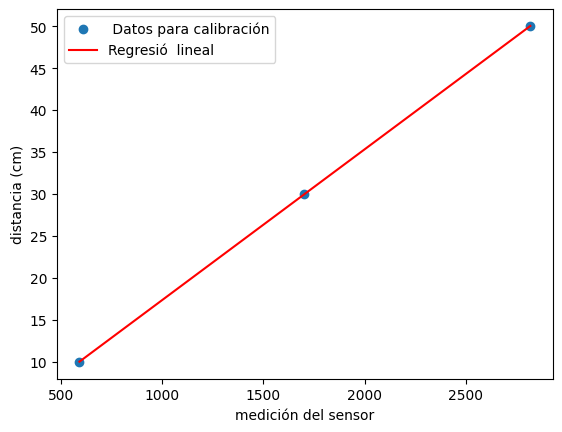

In [104]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
# mediciones sensor | distancia
mediciones = np.array([590,1700,2820])
x = np.array([10,30,50])

# hacemos regresion lineal para obtener la funcion que relaciona mediciones con distancias
def linear_function(x, m, b):
    return m * x + b

params, covariance = curve_fit(linear_function, mediciones, x)
slope, intercept = params

plt.scatter(mediciones, x, label=' Datos para calibración')
plt.plot(mediciones, linear_function(mediciones, slope, intercept), color='red', label='Regresió  lineal')
plt.xlabel('medición del sensor')
plt.ylabel('distancia (cm)')
plt.legend()
plt.show()


In [105]:
#podemos usar esta funcion para predecir distancias a partir de mediciones
nueva_medicion =  1000
nueva_distancia = linear_function(nueva_medicion, slope, intercept)
print(nueva_distancia)

17.38424001715939


In [106]:
# sabiendo que lo que devuelve el sensor es el tiempo que tarda en ir y volver el sonido podemos calcular la velocidad del sonido
# velocidad = distancia / tiempo

# para que quede en m/s:
# pasar de microsegundo a segundos
mediciones = mediciones / 1000000
# pasar cm a metros
x = x / 100

velocidad = 2 * x / mediciones   # 2* porque es ida y vuelta

print("velocidad del sonido: ", np.mean(velocidad), "m/s")

velocidad del sonido:  348.8447187986867 m/s


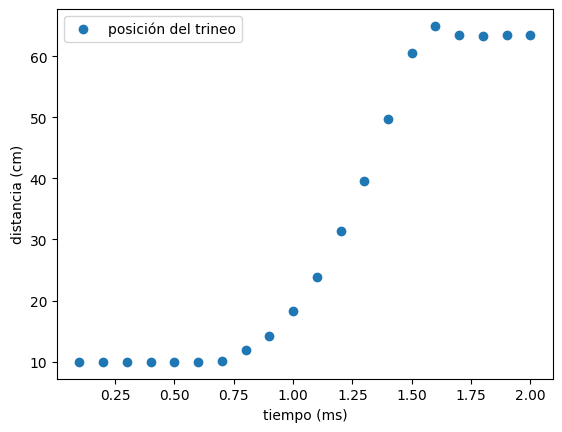

In [107]:
# hacemos lo mismo con los datos del sensor por ejemplo:
import pandas as pd

pd = pd.read_csv('./dataset/bronce_nada_.txt', sep=',', header=None)

t = pd[0].to_numpy() / 1000 # pasar de microsegundos a milisegundos
mediciones = pd[1].to_numpy()
x = linear_function(mediciones, slope, intercept)

#plot
plt.scatter(t, x, label='posición del trineo')
plt.xlabel('tiempo (ms)')
plt.ylabel('distancia (cm)')
plt.legend()
plt.show()



Los valores de i y j son:  6 4 len distancias 20
shapes (10,) (10,)


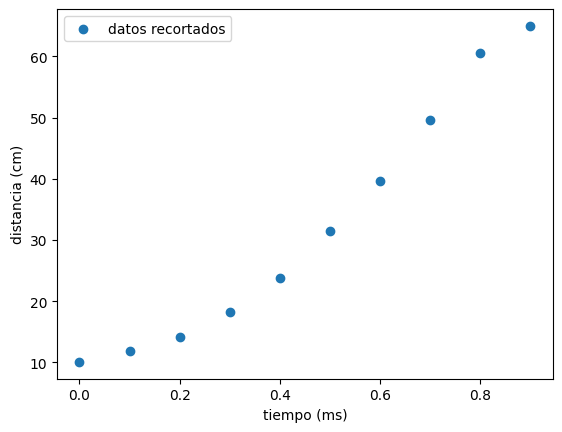

In [108]:
# veo que hay muchos tiempos demas asi que me armo una funcion que corte el principio y el final con un threshold de cambio de distancia
def cortar(tiempos,distancias,threshold):
    """dado un threshold cortar los tiempos desde el principio hasta que la diferencia en la distancia sea mayor a threshold. Lo mismo para el final"""
    for i in range(len(distancias)):
        if distancias[i+1]-distancias[i] > threshold:
            break

    # ahora desde el final hasta que la diferencia en la distancia sea mayor a threshold
    for j in range(len(distancias)):
        if distancias[-j-1]-distancias[-j-2] > threshold:
            break

    if -j == 0:
        j = 1

    if i == len(distancias) -1:
        i = 0
    print("Los valores de i y j son: ",i,j, "len distancias",len(distancias))
    print("shapes", tiempos[i:-j].shape,distancias[i:-j].shape)
    return tiempos[i:-j],distancias[i:-j]


t_cropped,x_cropped = cortar(t,x,0.55)

t_cropped = t_cropped - t_cropped[0] # para que empiece en 0

plt.scatter(t_cropped, x_cropped, label='datos recortados')
plt.xlabel('tiempo (ms)')
plt.ylabel('distancia (cm)')
plt.legend()
plt.show()

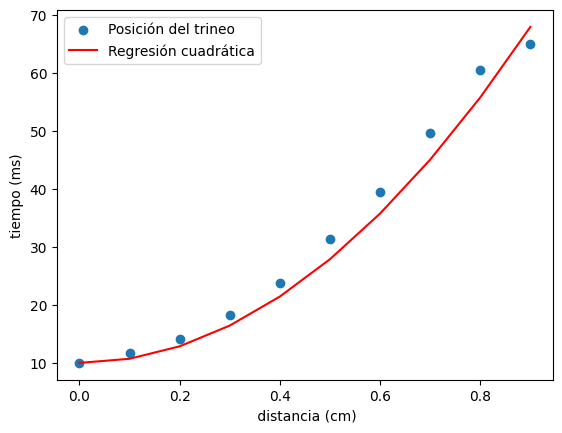

la aceleracion es:  142.9330976755962 cm/ms^2


In [109]:
# sabiendo que el trineo hace mruv puedo calcular la aceleración fiteando una cuadratica a la distancia vs tiempo
from scipy.optimize import curve_fit


def get_acceleration(x,y):

    # Define the quadratic function with b fixed to 0
    def quadratic_function(x, a, c):
        return a * x**2 + c

    # Perform the quadratic fit with b fixed to 0
    initial_guess = [0.01, y[0]]  # Initial guesses for 'a' and 'c'
    params, covariance = curve_fit(quadratic_function, x, y, p0=initial_guess)

    # Extract the fitted parameters
    a, c = params

    return 2*a

a = get_acceleration(t_cropped,x_cropped)

# ahora que tengo la aceleracion puedo hacer mruv y comparar con los datos para verificar que la aceleracion es correcta
def mruv(t,a,v0,x0):
    return 0.5*a*t**2 + v0*t + x0


x_pred = mruv(t_cropped,a,0,x_cropped[0])

plt.scatter(t_cropped, x_cropped, label='Posición del trineo')
plt.plot(t_cropped, x_pred, color='red', label='Regresión cuadrática')
plt.xlabel(' distancia (cm)')
plt.ylabel('tiempo (ms)')
plt.legend()
plt.show()

print("la aceleracion es: ",a,"cm/ms^2")


In [110]:
b = 72.76
s= 22.12
m_= 5.37
p = 69.59
t = 108.86
nombre_to_peso = {"bronce": b, "nada": t, "protoboard":t+p, "2protoboard": t+2*p, "broncesilvermadera":b+s+m_,"silvermadera":s+m_, "silver":s}


codigo principal que lee cada archivo y saca lo que necesitamos

['broncesilvermadera', 'nada', 'trineo', 'madera']


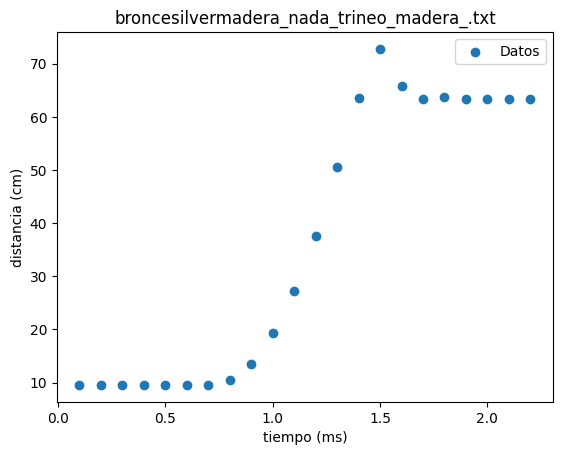

Los valores de i y j son:  6 6 len distancias 21
shapes (9,) (9,)
aceleracion 207.41969483308014


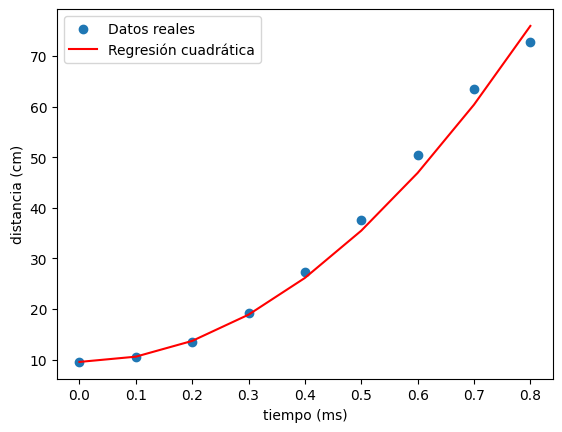

['bronce', '2protoboard', 'trineo', 'madera']


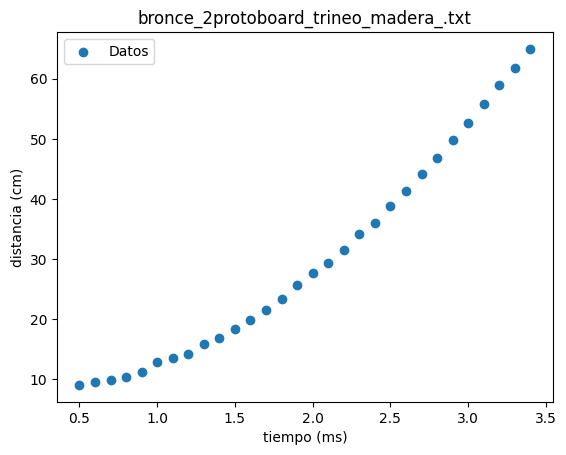

Los valores de i y j son:  3 1 len distancias 29
shapes (25,) (25,)
aceleracion 16.384410244129576


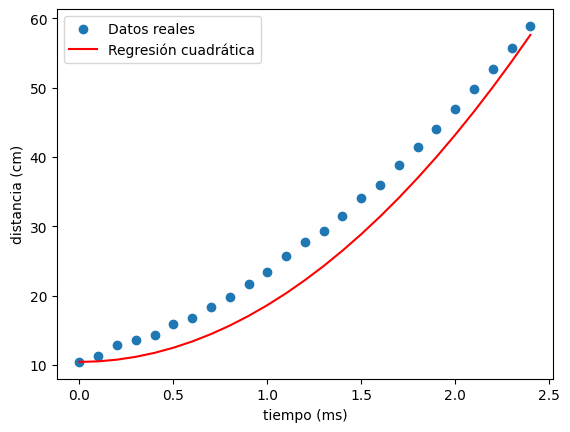

['bronce', 'nada', 'papel', 'papel']


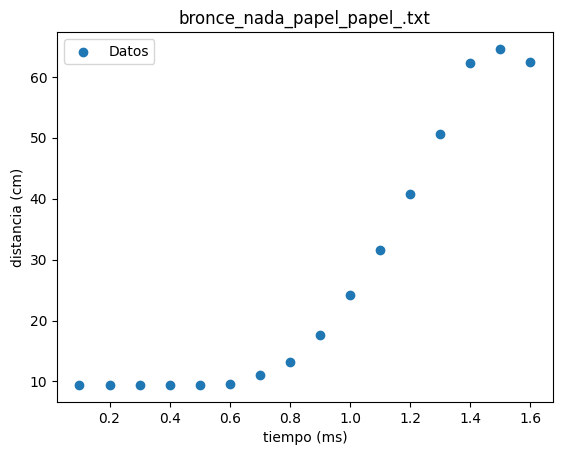

Los valores de i y j son:  5 1 len distancias 15
shapes (9,) (9,)
aceleracion 165.00459482351752


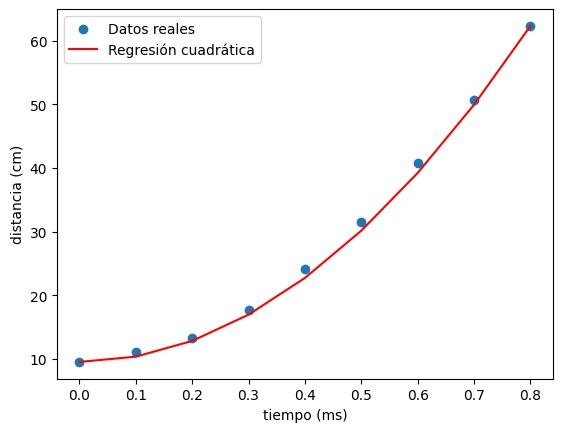

['bronce', 'nada', 'trineo', 'madera']


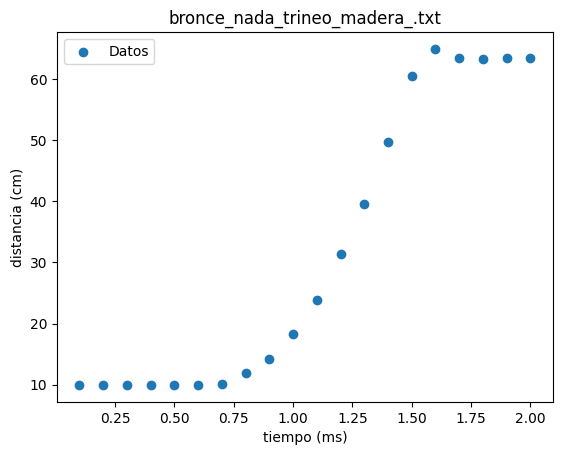

Los valores de i y j son:  6 3 len distancias 19
shapes (10,) (10,)
aceleracion 142.9330976755962


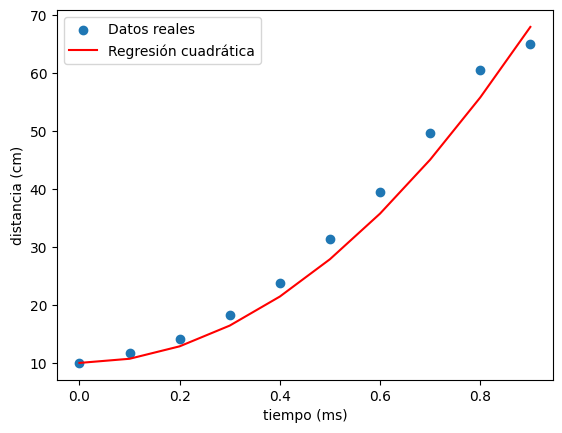

['bronce', 'nada', 'trineo', 'madera']


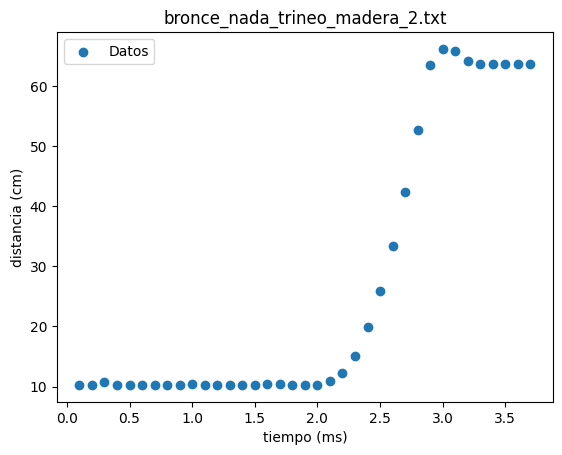

Los valores de i y j son:  19 6 len distancias 36
shapes (11,) (11,)
aceleracion 122.11809688835729


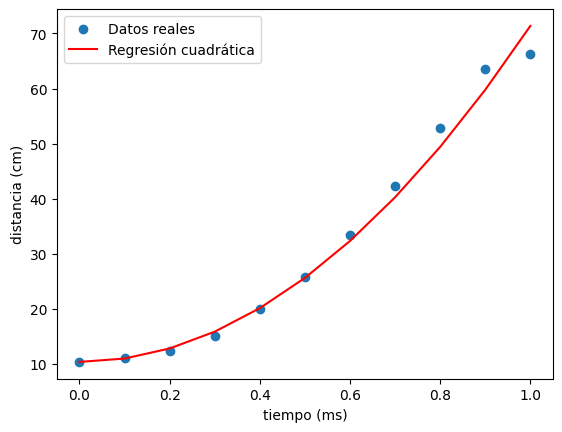

['bronce', 'nada', 'trineo', 'madera']


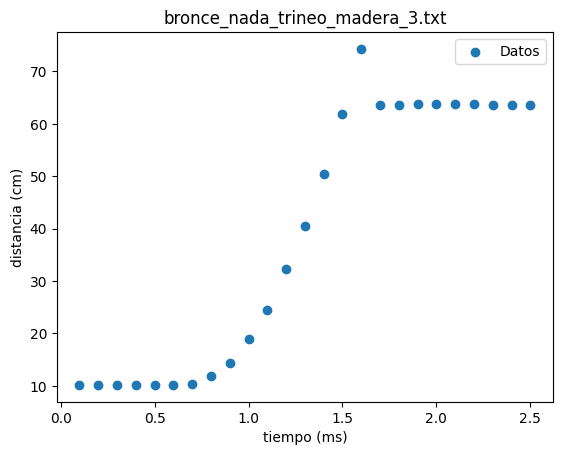

Los valores de i y j son:  6 8 len distancias 24
shapes (10,) (10,)
aceleracion 157.30989247696013


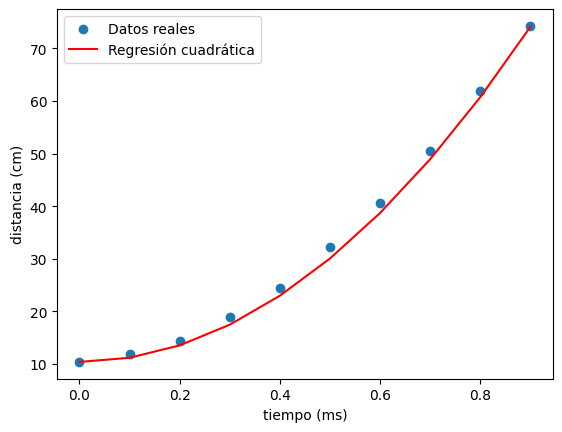

['bronce', 'nada', 'trineo', 'papel']


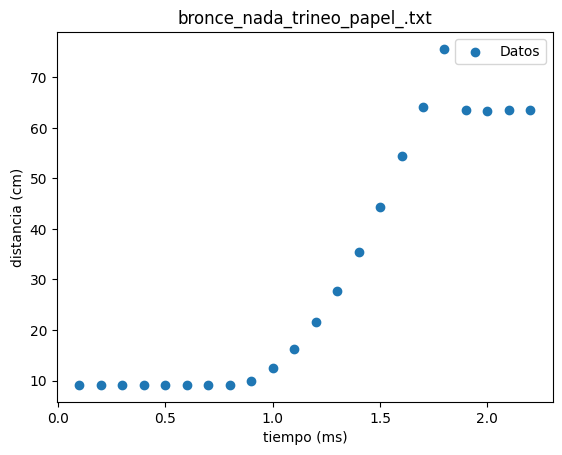

Los valores de i y j son:  7 3 len distancias 21
shapes (11,) (11,)
aceleracion 133.92167040518817


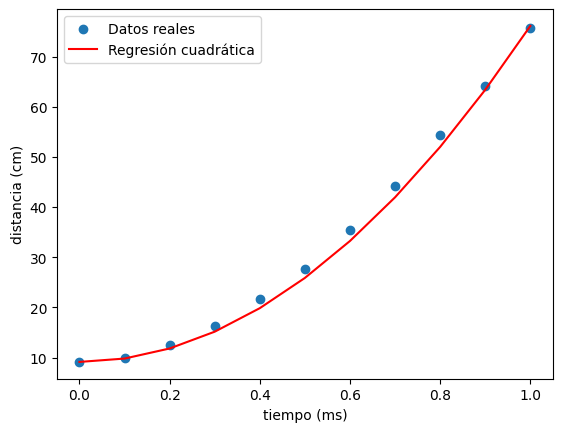

['bronce', 'protoboard', 'trineo', 'madera']


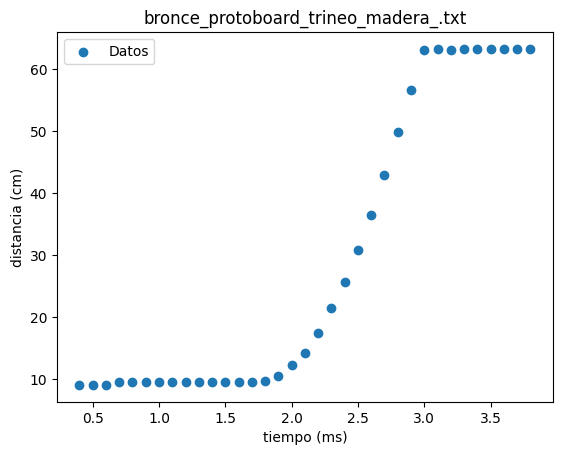

Los valores de i y j son:  14 7 len distancias 34
shapes (13,) (13,)
aceleracion 75.36328619335058


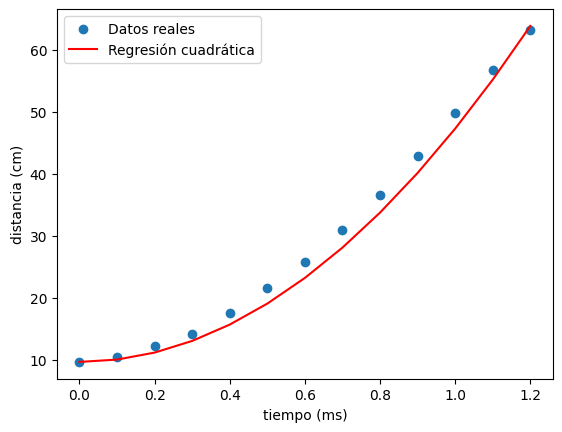

['silvermadera', 'nada', 'trineo', 'madera']


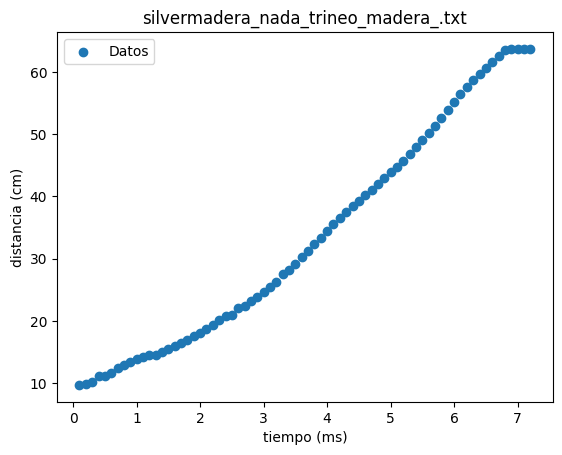

Los valores de i y j son:  2 3 len distancias 71
shapes (66,) (66,)
aceleracion 2.5177757478329768


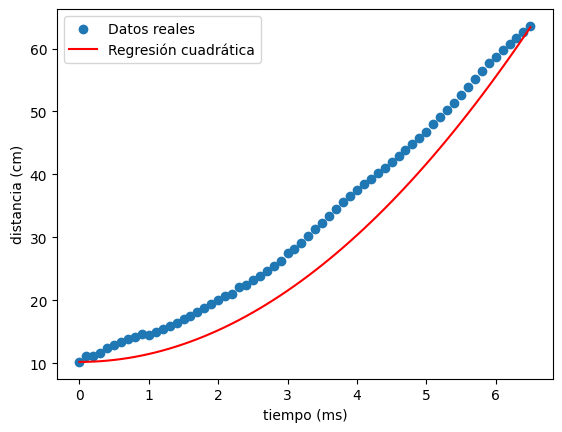

In [111]:
import os
import pandas as pd

# listas para guardar la masa y la aceleracion de cada experimento
M = []
m = []
materialTrineo = []
materialPiso = []
a = [] 

for file in os.listdir("./cropped_dataset"):
    name = file.split("_")[:-1]
    if len(name) != 4:
        raise Exception("El nombre del archivo no es valido")
    print(file.split("_")[:-1])
    #load data
    df = pd.read_csv('./cropped_dataset/'+file, sep=',', header=None)


    t = df[0].to_numpy() / 1000 # pasar de microsegundos a milisegundos
    mediciones = df[1].to_numpy()
    x = linear_function(mediciones, slope, intercept)

    # plot the data
    plt.title(file)
    plt.scatter(t, x, label='Datos')
    plt.xlabel('tiempo (ms)')
    plt.ylabel('distancia (cm)')
    plt.legend()
    plt.show()
    

    #crop data
    t_cropped,x_cropped = cortar(t[:-1],x[:-1],0.55)
    t_cropped = t_cropped - t_cropped[0] # para que empiece en 0

    #get acceleration
    acc2= get_acceleration(t_cropped, x_cropped)
    print("aceleracion",acc2)

    #plot mruv vs data
    x_pred = mruv(t_cropped,acc2,0,x_cropped[0])

    plt.scatter(t_cropped, x_cropped, label='Datos reales')
    plt.plot(t_cropped, x_pred, color='red', label='Regresión cuadrática')
    plt.xlabel('tiempo (ms)')
    plt.ylabel('distancia (cm)')
    plt.legend()
    plt.show()

    #plot acceleration
    # axs[2].scatter(t_cropped[::3][:-2], aceleraciones, label=' Datos para calibración')

    # save data
    M.append(nombre_to_peso[name[0]])
    m.append(nombre_to_peso[name[1]])
    materialTrineo.append(name[2])
    materialPiso.append(name[3])
    a.append(acc2)
    # show plot
    plt.show()


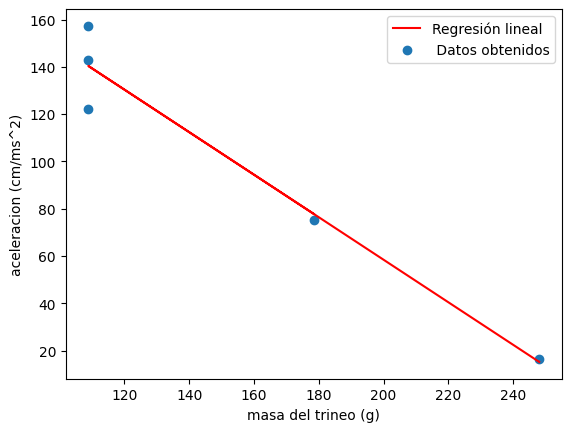

la pendiente es:  -0.8996136450529082 cm/ms^2/g
la ordenada es:  238.31616623361177 cm/ms^2


In [112]:
# plotear aceleracion vs masa con M fijo, y superficies fijas
m_filtro = []
a_filtro = []
for i in range(len(M)):
    if M[i] == nombre_to_peso["bronce"] and materialPiso[i] == "madera" and materialTrineo[i] == "trineo":
        m_filtro.append(m[i])
        a_filtro.append(a[i])

# aplicar regresion lineal
def linear_function(x, m, b):
    return m * x + b

params, covariance = curve_fit(linear_function, m_filtro, a_filtro)

slope, intercept = params


plt.plot(m_filtro, linear_function(np.array(m_filtro), slope, intercept), color='red', label='Regresión lineal')
plt.scatter(m_filtro, a_filtro, label=' Datos obtenidos')
plt.xlabel("masa del trineo (g)")
plt.ylabel("aceleracion (cm/ms^2)")
plt.legend()
plt.show()
print("la pendiente es: ",slope,"cm/ms^2/g")
print("la ordenada es: ",intercept,"cm/ms^2")


In [126]:
def mu_dinamico(a,m1,M2):
    g = 98
    return (M2 / m1) - (a*(m1+M2))/(m1*g)

In [131]:
# calculamos el mu dinamico
# de hacer las cuentas a mano sale que mu = (Mg - (m-M)a) / mg

mu = []
g = 98 # en cm/s^2  
for i in range(len(M)):
    if materialPiso[i] == "madera" and materialTrineo[i] == "trineo":# and a[i] < 100:

        mu_d = mu_dinamico(a[i]/10,m[i],M[i])
        # print("mu dinamico: ",a[i]/10,m[i],M[i], mu_d)
        mu.append(mu_d)

print("el mu dinamico promedio para trineo madera es: ", np.mean(mu))
print("std: ", np.std(mu))

el mu dinamico promedio para trineo madera es:  0.3744211322755683
std:  0.09415014730053872


In [130]:
# mu para papel papel
mu = []
for i in range(len(M)):
    if materialPiso[i] == "papel" and materialTrineo[i] == "papel":
        mu_d = mu_dinamico(a[i]/10,m[i],M[i])
        # print("mu dinamico: ",a[i]/10,m[i],M[i], mu_d)
        mu.append(mu_d)

print("el mu dinamico promedio para papel papel es: ", np.mean(mu), "std: ", np.std(mu))

# mu para papel trineo
mu = []
for i in range(len(M)):
    if materialPiso[i] == "papel" and materialTrineo[i] == "trineo":
        # print(i)
        mu_d = mu_dinamico(a[i]/10,m[i],M[i])
        # print("mu dinamico: ",a[i]/10,m[i],M[i], mu_d)
        mu.append(mu_d)

print("el mu dinamico promedio para papel trineo es: ", np.mean(mu), "std: ", np.std(mu))

el mu dinamico promedio para papel papel es:  0.38747263371558266 std:  0.0
el mu dinamico promedio para papel trineo es:  0.4403891369650003 std:  0.0


In [136]:
# coeficiente estatico
# para calcular Frmax propusimos el siguiente experimento:
# fijar M y variar m hasta encontrar el limite en el que el trineo pasa de estar en reposo a moverse
# para esto pusimos sobre el trineo una botella y fuimos agregando agua hasta que el trineo no se mueva 
# luego hicimos los contrario llenamos la botella y fuimos sacando agua hasta que el trineo se mueva
# con esto obtuvimos un limite superior y un limite inferior para m

# con pesa de silver 
Masa = nombre_to_peso["broncesilvermadera"]


# m = 375.62 g Limite poniendo agua
m1 = 375.62

# m= 216.44 g Limite sacando agua
m2 = 216.44

mu_estatico1 = Masa / m1

mu_estatico2 = Masa / m2

print("el mu estatico superior es: ", mu_estatico2)

print("el mu estatico inferior es: ", mu_estatico1)

#sacando agua - limite superior

el mu estatico superior es:  0.463176861947884
el mu estatico inferior es:  0.2668920717746659
